In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import DataLoader, Dataset
import os
import cv2
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
import math
from torch.nn import Parameter
import torch.optim as optim
import torchvision.transforms as transforms
import time
import torch.nn as nn
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, ReLU, Dropout, MaxPool2d, Sequential, Module

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
path_data = '/kaggle/input/model2-94logo/data_classification'

folder = os.listdir(path_data)
print(folder)
num_classes = len(folder)
print("Number of logos:", num_classes)

['bet365', 'cropped_Snapchat', 'danone', 'netflix', 'allianz', 'CNN', 'Prudential', 'prada', 'cropped_Chevrolet', 'Aljazeera', 'pointsbet', 'Reuters', 'metlife', 'National_Geographic', 'cropped_Gucci', 'cartier', 'Sheraton', 'cropped_Hermes', 'budweiser', 'aegon', 'TikTok', 'firefox', 'maybach', 'samsung', 'nvidia', 'cropped_H_and_M', 'nivea', 'Booking', 'Generali', 'paypal', 'Ritz_Carlton', 'ebay', 'gillette', 'cropped_Xiaomi', 'cropped_3M', 'oacle', 'dove', 'Airbnb', 'cropped_Lenovo', 'toyota', 'BK8', 'cropped_Audi', 'cropped_Panasonic', 'facebook', 'cropped_Dell', 'Fanduel', 'Marriott', 'rolex', '7up', 'BBC', 'dafabet', 'Hollywoodbet', 'mastercard', 'cropped_Dior', 'Unibet', 'avon', 'cropped_Shell', 'lamborghini', 'espn', 'sony', 'cropped_Asics', 'Bloomberg', 'volvo', 'ibm', 'bally', 'loreal', 'Forbes', 'betway', 'axa', 'Mercedes_Benz', 'cocacola', 'P_and_G', 'betmgm', 'acb', 'tencent', 'visa', 'cropped_Bosch', 'cropped_Zara', 'heineken', 'cropped_Volkswagen', 'cropped_Uniqlo', 'tis

In [4]:
INPUT_SIZE = (224, 224)
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize([int(INPUT_SIZE[0]), int(INPUT_SIZE[0])]), # smaller side resized
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ])

In [5]:
images = []
labels = []

In [6]:
# folder.sort()
# print(len(folder))
# print(folder)

# for i in range(len(folder)):
#     path_singer = os.path.join(path_data, folder[i])
#     print(len(os.listdir(path_singer)))

94
['7up', 'Airbnb', 'Aljazeera', 'BBC', 'BK8', 'Bloomberg', 'Booking', 'CNN', 'Discovery', 'Expedia', 'Fanduel', 'Forbes', 'Generali', 'Hilton', 'Hollywoodbet', 'J_and_J', 'Marriott', 'Mercedes_Benz', 'National_Geographic', 'P_and_G', 'Prudential', 'Reuters', 'Ritz_Carlton', 'Sheraton', 'TikTok', 'Unibet', 'acb', 'aegon', 'allianz', 'avon', 'axa', 'bally', 'bet365', 'betmgm', 'betrivers', 'betway', 'budweiser', 'cartier', 'cocacola', 'corona', 'cropped_3M', 'cropped_Asics', 'cropped_Audi', 'cropped_Bosch', 'cropped_Chevrolet', 'cropped_Colgate', 'cropped_Dell', 'cropped_Dior', 'cropped_Gucci', 'cropped_H_and_M', 'cropped_Hermes', 'cropped_Lenovo', 'cropped_Louis_Vuitton', 'cropped_Panasonic', 'cropped_Shell', 'cropped_Snapchat', 'cropped_Uniqlo', 'cropped_Volkswagen', 'cropped_Xiaomi', 'cropped_Zara', 'dafabet', 'danone', 'dove', 'draftkings', 'ebay', 'espn', 'facebook', 'firefox', 'gillette', 'heineken', 'ibm', 'instagram', 'lamborghini', 'loreal', 'mastercard', 'maybach', 'mcdonald'

In [7]:
for i in range(len(folder)):
    path_singer = os.path.join(path_data, folder[i])
    for j in os.listdir(path_singer):
        path_img = os.path.join(path_singer, j)
        img = cv2.imread(path_img)
        if img is not None:
            img = cv2.resize(img, INPUT_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(i)
            
print("OK")

OK


In [8]:
print("Number of images:", len(images))
print("Number of labels:", len(labels))
print(f"Shape of images array: {np.array(images).shape}")
print(f"Shape of labels array: {np.array(labels).shape}")

Number of images: 11207
Number of labels: 11207
Shape of images array: (11207, 224, 224, 3)
Shape of labels array: (11207,)


In [9]:
from sklearn.utils import shuffle

# Shuffle the training data
X_train, y_train = shuffle(images, labels, random_state=42)

print("Number of train image:", len(X_train))
print("Number of train label:", len(y_train))

Number of train image: 11207
Number of train label: 11207


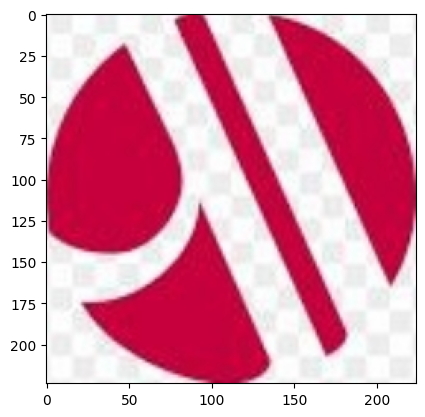

In [10]:
# Show image
plt.imshow(X_train[0])
plt.show()

In [31]:
class DataBasic(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [32]:
num_workers = os.cpu_count()

data_train = DataBasic(X_train, y_train, data_transform)

train_loader = DataLoader(dataset = data_train,
                         batch_size= 32,
                         shuffle = True,
                         num_workers = num_workers,)

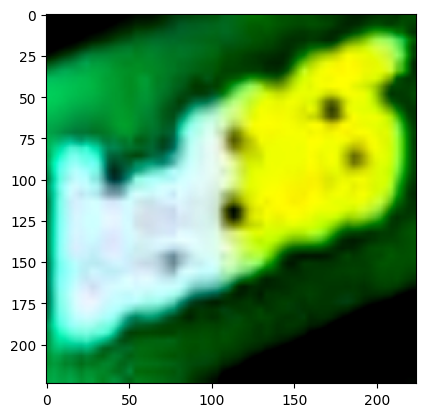

In [33]:
# Show image
x = next(iter(train_loader))
img = x[0][2]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [21]:
# from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
# import torch.nn.functional as F
# import torch
# from collections import namedtuple
# import math
# import pdb
# import torch.nn as nn

# ##################################  Arcface head #############################################################

# class Arcface(Module):
#     # implementation of additive margin softmax loss in https://arxiv.org/abs/1801.05599
#     def __init__(self, embedding_size=512, classnum=51332,  s=64., m=0.5):
#         super(Arcface, self).__init__()
#         self.classnum = classnum
#         self.kernel = Parameter(torch.Tensor(embedding_size,classnum))
#         # initial kernel
#         self.kernel.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
#         self.m = m # the margin value, default is 0.5
#         self.s = s # scalar value default is 64, see normface https://arxiv.org/abs/1704.06369
#         self.cos_m = math.cos(m)
#         self.sin_m = math.sin(m)
#         self.mm = self.sin_m * m  # issue 1
#         self.threshold = math.cos(math.pi - m)
#     def forward(self, embbedings, label):
#         # weights norm
#         nB = len(embbedings)
#         kernel_norm = l2_norm(self.kernel,axis=0)
#         # cos(theta+m)
#         cos_theta = torch.mm(embbedings,kernel_norm)
# #         output = torch.mm(embbedings,kernel_norm)
#         cos_theta = cos_theta.clamp(-1,1) # for numerical stability
#         cos_theta_2 = torch.pow(cos_theta, 2)
#         sin_theta_2 = 1 - cos_theta_2
#         sin_theta = torch.sqrt(sin_theta_2)
#         cos_theta_m = (cos_theta * self.cos_m - sin_theta * self.sin_m)
#         # this condition controls the theta+m should in range [0, pi]
#         #      0<=theta+m<=pi
#         #     -m<=theta<=pi-m
#         cond_v = cos_theta - self.threshold
#         cond_mask = cond_v <= 0
#         keep_val = (cos_theta - self.mm) # when theta not in [0,pi], use cosface instead
#         cos_theta_m[cond_mask] = keep_val[cond_mask]
#         output = cos_theta * 1.0 # a little bit hacky way to prevent in_place operation on cos_theta
#         idx_ = torch.arange(0, nB, dtype=torch.long)
#         output[idx_, label] = cos_theta_m[idx_, label]
#         output *= self.s # scale up in order to make softmax work, first introduced in normface
#         return output

# BackBone

### VGG16

##### #Custom FC head

In [ ]:
model_ = models.vgg16(pretrained=True)
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = model_.features

        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

##### #Get Full Head

In [2]:
# model_ = models.vgg16(pretrained=True)

# class Network(nn.Module):
#     def __init__(self, emb_dim=128):
#         super(Network, self).__init__()
#         self.conv = model_.features
        
#         # Full head của VGG16 gồm 3 Linear layers
#         self.base_classifier = model_.classifier  # Gồm cả 1000 lớp output

#         # Sau lớp 1000-d, thêm PReLU và chuyển về emb_dim
#         self.tail = nn.Sequential(
#             nn.PReLU(),
#             nn.Linear(1000, emb_dim)
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         x = self.base_classifier(x)
#         x = self.tail(x)
#         return x

### VGG19

##### #Custom FC head

In [ ]:
model_ = models.vgg19(pretrained=True)
class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()
        self.conv = model_.features

        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.conv(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

##### #Get Full Head

In [ ]:
# model_ = models.vgg19(pretrained=True)

# class Network(nn.Module):
#     def __init__(self, emb_dim=128):
#         super(Network, self).__init__()
#         self.conv = model_.features
        
#         self.base_classifier = model_.classifier

#         self.tail = nn.Sequential(
#             nn.PReLU(),
#             nn.Linear(1000, emb_dim)
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         x = self.base_classifier(x)
#         x = self.tail(x)
#         return x

### ResNet18

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()

        base_model = models.resnet18(pretrained=True)  
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, emb_dim)
        )

    def forward(self, x):
        x = self.backbone(x)           # [B, 512, 1, 1]
        x = torch.flatten(x, 1)        # [B, 512]
        x = self.fc(x)                 # [B, emb_dim]
        return x


### ResNet50

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()

        base_model = models.resnet50(pretrained=True)

        # Bỏ layer cuối cùng (fc)
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])  # Output: [B, 2048, 1, 1]

        # FC Head
        self.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.backbone(x)           # [B, 2048, 1, 1]
        x = torch.flatten(x, 1)        # [B, 2048]
        x = self.fc(x)                 # [B, emb_dim]
        return x

### MobileNetV2

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()

        base_model = models.mobilenet_v2(pretrained=True)

        # Bỏ classifier, giữ lại feature extractor
        self.backbone = base_model.features  # Output: [B, 1280, 7, 7]

        # Global Average Pooling + FC head
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: [B, 1280, 1, 1]

        self.fc = nn.Sequential(
            nn.Linear(1280, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.backbone(x)           # [B, 1280, 7, 7]
        x = self.pool(x)               # [B, 1280, 1, 1]
        x = torch.flatten(x, 1)        # [B, 1280]
        x = self.fc(x)                 # [B, emb_dim]
        return x


### MobileNetv3 - Small

In [34]:
# --------- Backbone Network ----------
class Network(nn.Module):
    def __init__(self, emb_dim=256):
        super(Network, self).__init__()
        base_model = models.mobilenet_v3_small(pretrained=True)
        self.backbone = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(576, 256),
            nn.PReLU(),
            nn.Linear(256, emb_dim)
        )

    def forward(self, x):
        x = self.backbone(x)         # [B, 576, 7, 7]
        x = self.pool(x)             # [B, 576, 1, 1]
        x = torch.flatten(x, 1)      # [B, 576]
        x = self.fc(x)               # [B, emb_dim]
        return x

### MobileNetv3 - Large

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class Network(nn.Module):
    def __init__(self, emb_dim=128):
        super(Network, self).__init__()

        base_model = models.mobilenet_v3_large(pretrained=True)

        # Lấy phần feature extractor
        self.backbone = base_model.features  # Output: [B, 960, 7, 7]

        # Global Average Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # [B, 960, 1, 1]

        # FC head
        self.fc = nn.Sequential(
            nn.Linear(960, 512),
            nn.PReLU(),
            nn.Linear(512, emb_dim)
        )

    def forward(self, x):
        x = self.backbone(x)   # [B, 960, 7, 7]
        x = self.pool(x)       # [B, 960, 1, 1]
        x = torch.flatten(x, 1)  # [B, 960]
        x = self.fc(x)         # [B, emb_dim]
        return x


# Loss

In [35]:
import torch
import torch.nn as nn
from torchvision import models
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from tqdm import tqdm

# --------- Focal Loss ----------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = nn.CrossEntropyLoss()

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

# --------- L2 Normalize ----------
def l2_norm(input, axis=1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output

# --------- ArcFace Head ----------
class Arcface(nn.Module):
    def __init__(self, embedding_size=256, classnum=1000, s=30.0, m=0.50):
        super(Arcface, self).__init__()
        self.classnum = classnum
        self.kernel = nn.Parameter(torch.Tensor(embedding_size, classnum))
        nn.init.xavier_uniform_(self.kernel)
        self.m = m
        self.s = s

    def forward(self, embbedings, label):
        embbedings = l2_norm(embbedings, axis=1)
        kernel_norm = l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(embbedings, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        theta = torch.acos(cos_theta)
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)
        output = torch.cos(theta + self.m)
        logits = self.s * (one_hot * output + (1.0 - one_hot) * cos_theta)
        return logits

# Set up

In [37]:
# --------- Config ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EMBEDDING_SIZE = 256
NUM_CLASS = len(folder)  # folder là list chứa tên class (ví dụ: folder = os.listdir(path))

# --------- Model ----------
BACKBONE = Network(emb_dim=EMBEDDING_SIZE).to(device)
HEAD = Arcface(embedding_size=EMBEDDING_SIZE, classnum=NUM_CLASS).to(device)

# --------- Loss, Optimizer, Scheduler ----------
LOSS = FocalLoss()
OPTIMIZER = optim.Adam(
    list(BACKBONE.parameters()) + list(HEAD.parameters()), 
    lr=0.001,  # thường nhỏ hơn SGD
    weight_decay=1e-4
)

SCHEDULER = StepLR(OPTIMIZER, step_size=10, gamma=0.1)

# Test Function

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from PIL import Image

preprocess = transforms.Compose([

    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def TEST(folder_path, model, transforms, key):

    label_org = []
    dir_org = []
    label_test = []
    dir_test_path = []
    dir_org_path = []
    REFER_DICT = {}

    # Put the model in evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        # Iterate over each subfolder in the folder_path
        for label_index, subfolder_name in enumerate(os.listdir(folder_path)):
            REFER_DICT[label_index] = subfolder_name
            subfolder_path = os.path.join(folder_path, subfolder_name)
            image_files = os.listdir(subfolder_path)
            for image_index, image_file in enumerate(image_files):

                image_path = os.path.join(subfolder_path, image_file)

                if key in image_path:

                    image = Image.open(image_path).convert('RGB')
                    image = transforms(image)
                    # Extract the embedding for the first image in the folder
                    embedding = model(image.unsqueeze(0).to("cuda"))
                    dir_org.append(embedding)
                    label_org.append(label_index)
                    dir_org_path.append(image_path)
                else:
                    # Store the path and label for other images
                    dir_test_path.append(image_path)
                    label_test.append(label_index)

        predict_label = []
        Max_sim = []

        # Iterate over test images
        for test_image_path in dir_test_path:

            test_image = Image.open(test_image_path).convert('RGB')
            test_image = transforms(test_image)

            # Extract the embedding for the test image
            test_embedding = model(test_image.unsqueeze(0).to("cuda"))
            similarities = []

            # Calculate cosine similarity with each original embedding
            for org_embedding in dir_org:

                cosine_sim = cosine_similarity(org_embedding.cpu().detach().numpy(), test_embedding.cpu().detach().numpy())
                similarities.append(cosine_sim[0][0])
            Max_sim.append(max(similarities))
            max_similarity_index = np.argmax(similarities)

            predict_label.append(label_org[max_similarity_index])

        accuracy = accuracy_score(predict_label, label_test)

        # VISUAL_fail = []
        # VISUAL_great = []

        # for idx, item in enumerate(predict_label):
        #   if item != label_test[idx]:
        #     VISUAL_fail.append([REFER_DICT[item], REFER_DICT[label_test[idx]], dir_test_path[idx], dir_org_path[item], Max_sim[idx]])
        #   else:
        #     VISUAL_great.append([REFER_DICT[item], REFER_DICT[label_test[idx]], dir_test_path[idx], dir_org_path[item], Max_sim[idx]])
        print(f'----Accuracy: {accuracy:.4f}')
        print()

# Train loop

In [40]:
# --------- Training Loop ----------
EPOCHS = 20
for epoch in range(EPOCHS):
    BACKBONE.train()
    HEAD.train()
    epoch_loss = []

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = images.to(device)
        labels = labels.to(device)

        features = BACKBONE(images)  # (B, emb_dim)
        logits = HEAD(features, labels)  # (B, num_classes)
        loss = LOSS(logits, labels)

        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        epoch_loss.append(loss.item())

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.4f}")

    SCHEDULER.step()

    # Save checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save({
            "backbone": BACKBONE.state_dict(),
            "head": HEAD.state_dict()
        }, f"checkpoint_epoch{epoch+1}.pth")

        test_path = "/kaggle/input/logo-verify-test/logo_verify_test"  # ví dụ: TEST_SET/
        model = BACKBONE  # hoặc pipeline nếu có thêm head
        key = "000000"    # ảnh gốc tham chiếu
        accuracy = TEST(test_path, BACKBONE, preprocess, key)

Epoch 1/20: 100%|██████████| 351/351 [00:17<00:00, 19.73it/s]


Epoch [1/20] - Loss: 7.1525


Epoch 2/20: 100%|██████████| 351/351 [00:18<00:00, 19.17it/s]


Epoch [2/20] - Loss: 1.0961


Epoch 3/20: 100%|██████████| 351/351 [00:17<00:00, 19.65it/s]


Epoch [3/20] - Loss: 0.4176


Epoch 4/20: 100%|██████████| 351/351 [00:18<00:00, 19.11it/s]


Epoch [4/20] - Loss: 0.2672


Epoch 5/20: 100%|██████████| 351/351 [00:18<00:00, 18.90it/s]


Epoch [5/20] - Loss: 0.1895


Epoch 6/20: 100%|██████████| 351/351 [00:18<00:00, 18.65it/s]


Epoch [6/20] - Loss: 0.2911


Epoch 7/20: 100%|██████████| 351/351 [00:18<00:00, 19.45it/s]


Epoch [7/20] - Loss: 0.2323


Epoch 8/20: 100%|██████████| 351/351 [00:18<00:00, 18.62it/s]


Epoch [8/20] - Loss: 0.0603


Epoch 9/20: 100%|██████████| 351/351 [00:19<00:00, 17.83it/s]


Epoch [9/20] - Loss: 0.0595


Epoch 10/20: 100%|██████████| 351/351 [00:17<00:00, 19.50it/s]


Epoch [10/20] - Loss: 0.0979
----Accuracy: 0.6919



Epoch 11/20: 100%|██████████| 351/351 [00:18<00:00, 19.44it/s]


Epoch [11/20] - Loss: 0.0214


Epoch 12/20: 100%|██████████| 351/351 [00:17<00:00, 19.54it/s]


Epoch [12/20] - Loss: 0.0073


Epoch 13/20: 100%|██████████| 351/351 [00:18<00:00, 18.93it/s]


Epoch [13/20] - Loss: 0.0049


Epoch 14/20: 100%|██████████| 351/351 [00:17<00:00, 19.59it/s]


Epoch [14/20] - Loss: 0.0203


Epoch 15/20: 100%|██████████| 351/351 [00:18<00:00, 18.99it/s]


Epoch [15/20] - Loss: 0.0049


Epoch 16/20: 100%|██████████| 351/351 [00:17<00:00, 19.58it/s]


Epoch [16/20] - Loss: 0.0037


Epoch 17/20: 100%|██████████| 351/351 [00:17<00:00, 19.92it/s]


Epoch [17/20] - Loss: 0.0023


Epoch 18/20: 100%|██████████| 351/351 [00:16<00:00, 20.81it/s]


Epoch [18/20] - Loss: 0.0017


Epoch 19/20: 100%|██████████| 351/351 [00:17<00:00, 20.37it/s]


Epoch [19/20] - Loss: 0.0016


Epoch 20/20: 100%|██████████| 351/351 [00:16<00:00, 21.00it/s]


Epoch [20/20] - Loss: 0.0011
----Accuracy: 0.7330

